# Analyse des catégories <mark>=> pas à sa place</mark>

Les analyses monovariées des variables qualitatives nous ont déjà livré les modalités et fréquences d'emploi.

La liste des modalités c'est le lexique des valeurs que peut prendre une variable.

Nous interrons ici, en partant d'analyses bivariées, aux corrélations logiques entre les variables catégorielles.

L'objectif est d'optimiser la partition des segments principaux du jeu de données, et la simplification catégorielle.

Dis comme cela, c'est abstrait.. prenons donc un exemple concret :
* Les deux segments résidentiel et non-résidentiel sont définis à partir d'un sélecteur (expression logique à base de boolean arrays). Cette expression logique est ajustée en fonction de l'analyse des coïncidences de modalités, et notamment de leur fréquence. Ici, les ouliers sont plutôt ceux qui semblent être mal classés, et qu'il faut reclasser.

... expliquer cela clairement

# Vérification de cohérence : relations linéaires a priori

<mark>TODO</mark> améliorer cette partie : enregistrer ces outliers et investiguer.

NB > les mêmes apparaissent plusieurs fois, cf. P3. Faire un SNS noyau lisse.

Vérifications de cohérence fondées sur l'hypothèse d'existence d'une relation linéaire, sans constante additive, entre deux ou trois variables : $y = ax$ ou $z = ax + by$, avec $a, b$ constants.

**NB** > les études menées dans ce notebook montrent, s'ils fallait encore s'en convaincre, la supériorité de la médiane  sur la moyenne en tant que détecteur de tendance centrale. Sa puissance tient tout entière dans sa résistance aux outliers.

## Chargements

## Libs

In [1]:
from pepper_commons import *
from pepper_bivar import assert_relation, exclude_aberrants, assert_const_ratio
from pepper_production import *
from seattle_commons import clean_dataset
from seattle_commons import ratio_histo
from seattle_commons import display_outliers, display_aberrants

## Dataset

Data source : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

In [2]:
data = get_data()
_data, not_compliant, outliers = clean_dataset(data)


Removal of outliers


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,98101.0,0942000045,7,DOWNTOWN,47.60642,-122.33581,1958,1.0,6,172842,25920,146922,"Data Center, Office, Parking",Office,99890.0,Data Center,39336.0,Parking,25000.0,NaN,NaN,297.399994,299.200012,909.599976,911.500000,4.139950e+07,4.165040e+07,0.0,1.166315e+07,39794668.0,16048.309570,1604831.0,Non-Compliant,High outlier,362.66,2.10
384,539,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,98105.0,5335200380,4,NORTHEAST,47.66178,-122.31812,1987,1.0,2,69492,0,69492,Retail Store,Retail Store,69800.0,Other,0.0,NaN,NaN,NaN,100.0,4.600000,4.600000,14.300000,14.300000,3.189628e+05,3.189628e+05,0.0,9.348260e+04,318963.0,0.000000,0.0,Non-Compliant,Low outlier,2.22,0.03
448,608,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,98104.0,5247800200,2,DOWNTOWN,47.59878,-122.33458,1913,5.0,7,154159,0,154159,Office,Office,193154.0,NaN,NaN,NaN,NaN,NaN,100.0,58.000000,58.799999,28.000000,28.700001,1.119592e+07,1.134876e+07,0.0,4.715030e+05,1608768.0,3430.500488,343050.0,Non-Compliant,Low outlier,29.43,0.19
517,704,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,98119.0,7666202110,7,MAGNOLIA / QUEEN ANNE,47.62235,-122.36378,2000,1.0,4,129551,42500,87051,"Data Center, Office, Parking",Office,82273.0,Parking,42500.0,Data Center,4778.0,NaN,1.0,311.700012,311.700012,978.900024,978.900024,2.713719e+07,2.713719e+07,0.0,7.953454e+06,27137187.0,0.000000,0.0,Non-Compliant,High outlier,189.18,1.46
720,19708,Multifamily HR (10+),High-Rise Multifamily,Bay Vista,2821 2nd Ave,98121.0,0586400000,7,DOWNTOWN,47.61706,-122.35141,1982,1.0,24,167941,0,167941,"Multifamily Housing, Swimming Pool",Multifamily Housing,138787.0,Parking,99952.0,Swimming Pool,0.0,NaN,100.0,17.299999,18.700001,50.400002,54.000000,2.407904e+06,2.589126e+06,0.0,6.265616e+05,2137828.0,2700.760010,270076.0,Non-Compliant,Low outlier,29.25,0.17


⇒ 32 outliers + Outlier column dropped

Removal of not compliant


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
22,28,SPS-District K-12,K-12 School,Graham Hill Elementary,5149 S. Graham St.,98118.0,1102000138,2,SOUTHEAST,47.54576,-122.26853,1961,1.0,2,56228,0,56228,K-12 School,K-12 School,58916.0,NaN,NaN,NaN,NaN,NaN,95.0,26.100000,29.100000,60.700001,64.599998,1539478.5,1713623.5,0.0,274605.9063,936955.0,6025.229004,602523.0,Error - Correct Default Data,38.53,0.69
28,34,SPS-District K-12,K-12 School,Meany Building,301/300 21st Ave. E.,98112.0,0688000090,3,Central,47.62266,-122.30547,1955,1.0,1,126351,0,126351,K-12 School,K-12 School,126351.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,Missing Data,0.00,0.00
30,36,SPS-District K-12,K-12 School,Jane Addams Middle,11051 34th Ave. N.E.,98125.0,0752000170,5,NORTH,47.70994,-122.29301,1949,1.0,2,160645,0,160645,K-12 School,K-12 School,164229.0,NaN,NaN,NaN,NaN,NaN,75.0,41.299999,47.500000,68.099998,75.699997,6779173.0,7800349.5,0.0,570809.1875,1947601.0,48315.718750,4831572.0,Error - Correct Default Data,270.18,1.68
31,37,SPS-District K-12,K-12 School,John Hay Elementary,201 Garfield St.,98109.0,0809000005,7,MAGNOLIA / QUEEN ANNE,47.63290,-122.35172,1989,1.0,2,51582,0,51582,K-12 School,K-12 School,55166.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,438691.6875,1496816.0,0.000000,0.0,Missing Data,10.43,0.20
38,51,SPS-District K-12,K-12 School,Eckstein Middle,3003 N.E. 75th St.,98115.0,0425049022,4,NORTHEAST,47.68252,-122.29498,1950,1.0,2,175565,0,175565,K-12 School,K-12 School,182861.0,NaN,NaN,NaN,NaN,NaN,88.0,35.000000,40.099998,55.000000,60.400002,6399127.5,7329817.5,0.0,468840.5000,1599684.0,47994.433590,4799443.0,Error - Correct Default Data,266.05,1.52


⇒ 133 not compliant + ComplianceStatus column dropped


# ✔ Gaz (kBtu vs therms)

Etude du rapport entre :
* `'NaturalGas(kBtu)'`
* `'NaturalGas(therms)'`

Bilan :
* Rapport parfait : $G_{kBtu} = 100 G_{therms}$ ($\sigma=0$)
* Exclusion de 4 (NaN, NaN) [1768, 2321, 2480, 3348].
* Pas d'outlier.

# excluded : 4
# confirmed : 3207
consistancy : all is consistant!
median ratio : 1.0
mean ratio : 1.0
ratio std dev : 0.0
ratio kurtosis : 434.332
ratio skew : 6.531


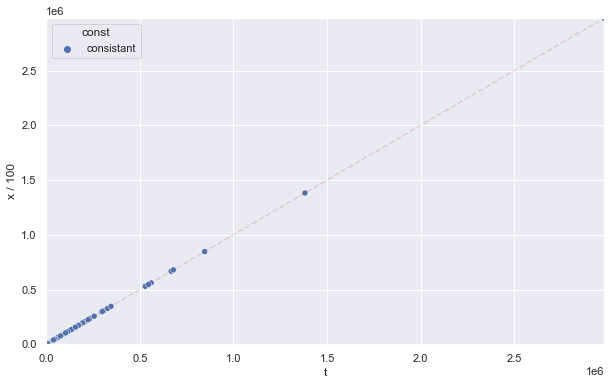

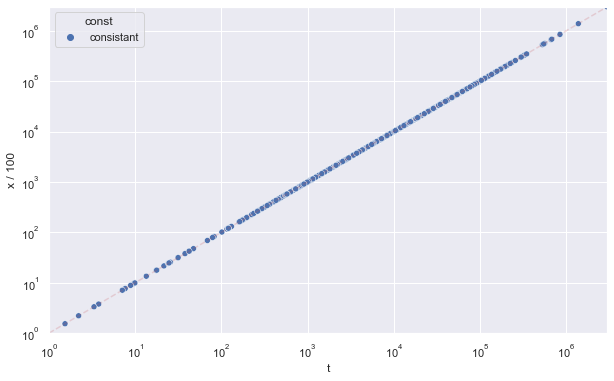

In [48]:
ok, ko, re, ab = assert_relation(
    data=_data,
    features=['NaturalGas(kBtu)'],
    target='NaturalGas(therms)',
    relation='x / 100'
)

In [45]:
display(ab)

,x,t,x / 100
1768,NaN,NaN,NaN
2321,NaN,NaN,NaN
2480,NaN,NaN,NaN
3348,NaN,NaN,NaN


# ✔ Electricité (kBtu vs. kWh)

Etude du rapport entre :
* `'Electricity(kWh)'`
* `'Electricity(kBtu)'`

Bilan :
* Rapport presque parfait : $E_{kBtu} = 3.412 E_{kWh}$ ($\sigma=0.007$)
* Exclusion de 4 (NaN, NaN), les mêmes que pour le gaz [1768, 2321, 2480, 3348].
* 1 outlier expliqué par l'erreur de troncature [1670]

# excluded : 4
# confirmed : 3207
# inconsistancies (ε = 1 / 1000) : 1 (0.031 %)
median ratio : 3.412
mean ratio : 3.412
ratio std dev : 0.007
ratio kurtosis : 3203.999
ratio skew : -56.604


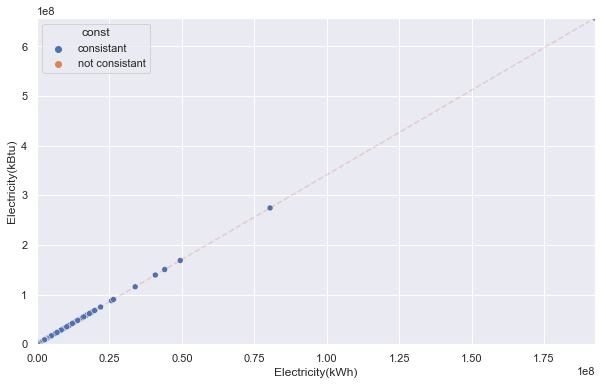

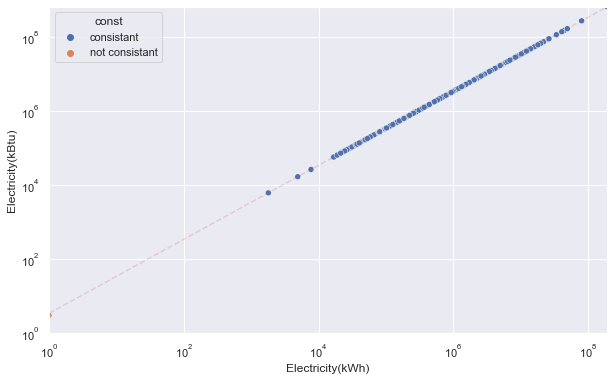

In [4]:
re, ab = exclude_aberrants(_data, ['Electricity(kWh)', 'Electricity(kBtu)'])
ok, ko = assert_const_ratio(re, 'Electricity(kWh)', 'Electricity(kBtu)')

#### Outliers

Les aberrants ne sont pas aberrants. Ce sont 3 bâtiments qui semblent ne pas consommer d'électricité, ce qui semble indiquer qu'ils la produisent de manière autonome.

Le premier, Pier 57 ne consommerait que du gaz (100 % de son mix).

Pour les deux autres, IUC- Whole Foods Interbay et Minor Tower Apartments, c'est plus délicat :

1. la ventilation indique 0 pour chacune des 3 sources principales d'énergie,
2. la consommation site n'est pas nulle,
3. la consommation source est nulle.

https://www.apartments.com/2525-minor-ave-e-seattle-wa-unit-207/l8fcfwe/ : *Electricity (Seattle City Light) - Resident responsibility*

https://foursquare.com/v/whole-foods-market/4ad90bfff964a5207f1721e3

La conclusion pour Minor Tower Apartments, c'est que l'énergie consommée par le site est calculée sur la base de la consommation des résidents, mais que le site et son propriétaire n'ont pas de contrat direct avec la ville.

Pour Whole Foods Interbay, pas de conclusion à ce stade.


In [5]:
display(ab)
display(data.loc[ab.index])
display(data[data.columns[29:40]].loc[ab.index])

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity
1768,23355,Multifamily LR (1-4),Low-Rise Multifamily,GRAHAM VIEW,6040 CALIFORNIA AVE SW,98136.0,7625703280,1,SOUTHWEST,47.54731,...,5.636832e+05,5.937986e+05,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
2321,25431,Multifamily LR (1-4),Low-Rise Multifamily,PONDERAY APTS,5625 15TH AVE NE,98105.0,5226300030,4,NORTHEAST,47.67025,...,7.702755e+05,7.975070e+05,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
2480,25763,Multifamily LR (1-4),Low-Rise Multifamily,Villa Andora,1520 CALIFORNIA AVE SW,98116.0,9272201340,1,SOUTHWEST,47.58968,...,1.049639e+06,1.126782e+06,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
3348,50082,Multifamily LR (1-4),Low-Rise Multifamily,STREAM FIFTEEN,605 15TH AVE E,98112.0,3303700030,3,EAST,47.62441,...,8.202201e+05,8.576127e+05,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1768,23355,2016,Multifamily LR (1-4),Low-Rise Multifamily,GRAHAM VIEW,6040 CALIFORNIA AVE SW,Seattle,WA,98136.0,7625703280,...,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN
2321,25431,2016,Multifamily LR (1-4),Low-Rise Multifamily,PONDERAY APTS,5625 15TH AVE NE,Seattle,WA,98105.0,5226300030,...,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN
2480,25763,2016,Multifamily LR (1-4),Low-Rise Multifamily,Villa Andora,1520 CALIFORNIA AVE SW,Seattle,WA,98116.0,9272201340,...,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN
3348,50082,2016,Multifamily LR (1-4),Low-Rise Multifamily,STREAM FIFTEEN,605 15TH AVE E,Seattle,WA,98112.0,3303700030,...,NaN,NaN,NaN,NaN,False,NaN,Compliant,NaN,NaN,NaN


,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
1768,19.200001,20.200001,NaN,NaN,5.636832e+05,5.937986e+05,NaN,NaN,NaN,NaN,NaN
2321,27.100000,28.000000,NaN,NaN,7.702755e+05,7.975070e+05,NaN,NaN,NaN,NaN,NaN
2480,34.500000,37.000000,NaN,NaN,1.049639e+06,1.126782e+06,NaN,NaN,NaN,NaN,NaN
3348,30.100000,31.500000,NaN,NaN,8.202201e+05,8.576127e+05,NaN,NaN,NaN,NaN,NaN


L'outlier est l'[Evergreen Washelli Memorial Park](https://en.wikipedia.org/wiki/Evergreen_Washelli_Memorial_Park).

C'est le plus grand cimetière de Seattle, 58 ha (144 acres).

La divergence d'avec la norme vient de l'erreur de troncature (arrondi à l'entier le plus proche) cf. couple $x, y* proche de l'unité. En effet, le cimetière est champion en termes de non consommation d'énergie rapportée à sa surface. Il semble représenter la meilleure solution face au problème du réchauffement climatique.

In [7]:
display(ko)
display(data.loc[ko.index])
display(data[data.columns[29:40]].loc[ko.index])

,Electricity(kWh),Electricity(kBtu),ratio
1670,1.0,3.0,3.0


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1670,23064,2016,NonResidential,Other,Evergreen Washelli,11111 Aurora Ave. N,Seattle,WA,98133.0,3026049008,...,1.0,3.0,34758.00781,3475801.0,False,NaN,Compliant,NaN,184.6,7.97


,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
1670,150.0,157.5,157.5,165.399994,3475804.25,3648465.5,0.0,1.0,3.0,34758.00781,3475801.0


# WN (Weather Normalized)

Etude du rapport entre :
* `'SiteEnergyUse(kBtu)'`
* `'SiteEnergyUseWN(kBtu)'`

Bilan :
* Rapport quasi constant : $E_{WN} = 1.052 E$ ($\sigma=0.075$)
* Exclusion d'un unique $E_{WN}$ à NaN.
* 13 outliers de deux natures :
    - 2 dont le rapport s'établit à 0.7 (-30 %) [98, 3206] : un hôpital et le Bullit Center, le bâtiment le + vert du monde.
    - 11 dont $E_{WN} = 0$ [220, 247, 284, 350, 882, 953, 3274, 3275, 3277, 3302, 3323]

Traitements :
* Passer les 11 $E_{WN}$ de 0 à NaN : la valeur 0 est n'a pas de sens.
* Définir deux classes à traduire numériquement de la manière la plus pertinente : les 1.052, les 0.7

# excluded : 1
# confirmed : 3210
# inconsistancies (ε = 1 / 1000) : 13 (0.405 %)
median ratio : 1.052
mean ratio : 1.052
ratio std dev : 0.075
ratio kurtosis : 129.449
ratio skew : -9.277


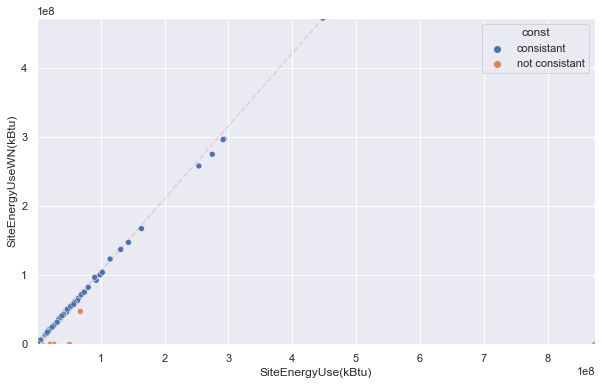

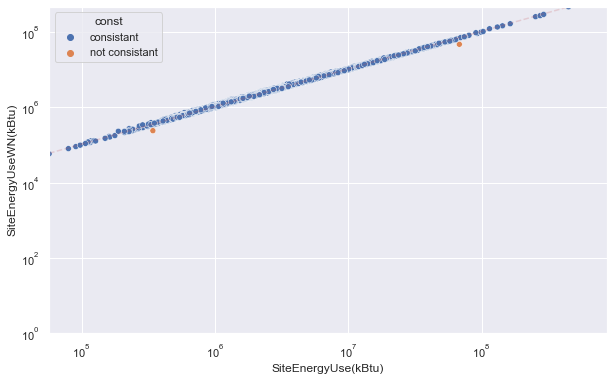

In [93]:
re, ab = exclude_aberrants(_data, ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'])
ok, ko = assert_const_ratio(re, 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', err=.2)

In [94]:
display(ab)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity
563,757,NonResidential,Large Office,Market Place I & II-2003 Western Avenue,2003 Western Avenue,98121.0,1977200280,7,DOWNTOWN,47.61051,...,5177270.5,NaN,0.0,1427645.25,4871126.0,14160.40918,1416041.0,False,109.16,0.83


In [95]:
display(ko)
display(data.loc[ko.index])
display(data[data.columns[29:40]].loc[ko.index])
# TODO : faire plus compact pour plus lisible : 1 seul tableu, pas 3, et séparer les deux types d'outliers

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),ratio
98,6.809073e+07,4.760272e+07,0.699107
220,2.490613e+07,0.000000e+00,0.000000
247,2.682322e+07,0.000000e+00,0.000000
284,5.446624e+06,0.000000e+00,0.000000
350,3.484916e+06,0.000000e+00,0.000000
882,4.964773e+05,0.000000e+00,0.000000
953,1.128179e+06,0.000000e+00,0.000000
3206,3.427261e+05,2.401321e+05,0.700653
3274,8.739237e+08,0.000000e+00,0.000000
3275,5.000717e+06,0.000000e+00,0.000000


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
98,147,2016,NonResidential,Hospital,Swedish Ballard,5300 Tallman Ave NW,Seattle,WA,98107.0,2767703875,...,1.032743e+07,35237205.0,328535.125000,32853512.0,False,NaN,Compliant,NaN,1990.50,6.98
220,343,2016,NonResidential,Large Office,Norton Building,801 2nd Ave Suite 1300,Seattle,WA,98104.0,0939000355,...,4.098788e+06,13985064.0,0.000000,0.0,False,NaN,Compliant,NaN,940.47,2.48
247,372,2016,NonResidential,Large Office,Metropolitan Park East,1730 Minor Avenue,Seattle,WA,98101.0,0660002410,...,7.796691e+06,26602310.0,2209.050049,220905.0,False,NaN,Compliant,NaN,197.19,0.40
284,414,2016,NonResidential,Large Office,Onni 1411 Fourth Development LP,1411 4TH AVE,Seattle,WA,98101.0,1975700345,...,7.610041e+05,2596546.0,0.000000,0.0,False,NaN,Compliant,NaN,238.09,1.58
350,493,2016,NonResidential,Small- and Mid-Sized Office,200 First Ave W,200 1ST AVE W,Seattle,WA,98119.0,1989201020,...,1.021370e+06,3484915.0,0.000000,0.0,False,NaN,Compliant,NaN,24.29,0.28
882,20130,2016,NonResidential,Worship Facility,Green Lake United Methodist Church,6415 1st ave ne,Seattle,WA,98115.0,1257200735,...,4.896690e+04,167075.0,3294.021729,329402.0,False,NaN,Compliant,NaN,18.66,0.78
953,20324,2016,NonResidential,Worship Facility,Temple Beth Am,2632 NE 80th St.,Seattle,WA,98115.0,1513800009,...,2.082293e+05,710478.0,4177.007813,417701.0,False,NaN,Compliant,NaN,27.14,0.86
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,98122.0,7234600195,...,-3.382680e+04,-115417.0,0.000000,0.0,False,NaN,Compliant,NaN,-0.80,-0.02
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,98105.0,1625049001,...,1.925775e+08,657074389.0,0.000000,0.0,False,NaN,Compliant,NaN,11140.56,1.20
3275,49968,2016,NonResidential,University,Aerospace,3795 E Stevens Way NE,Seattle,WA,98195.0,1625049001,...,1.090040e+06,3719217.0,0.000000,0.0,False,NaN,Compliant,NaN,25.93,0.44


,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu)
98,225.000000,157.300003,479.500000,251.800003,6.809073e+07,4.760272e+07,0.00,1.032743e+07,35237205.0,328535.125000,32853512.0
220,105.199997,0.000000,240.899994,0.000000,2.490613e+07,0.000000e+00,10921066.00,4.098788e+06,13985064.0,0.000000,0.0
247,73.000000,0.000000,227.899994,0.000000,2.682322e+07,0.000000e+00,0.00,7.796691e+06,26602310.0,2209.050049,220905.0
284,43.400002,0.000000,92.300003,0.000000,5.446624e+06,0.000000e+00,2850077.75,7.610041e+05,2596546.0,0.000000,0.0
350,50.000000,0.000000,157.000000,0.000000,3.484916e+06,0.000000e+00,0.00,1.021370e+06,3484915.0,0.000000,0.0
882,20.700001,0.000000,36.400002,0.000000,4.964773e+05,0.000000e+00,0.00,4.896690e+04,167075.0,3294.021729,329402.0
953,37.599998,0.000000,89.000000,0.000000,1.128179e+06,0.000000e+00,0.00,2.082293e+05,710478.0,4177.007813,417701.0
3206,7.100000,5.000000,2.000000,-2.100000,3.427261e+05,2.401321e+05,0.00,-3.382680e+04,-115417.0,0.000000,0.0
3274,93.800003,0.000000,246.600006,0.000000,8.739237e+08,0.000000e+00,84985240.00,1.925775e+08,657074389.0,0.000000,0.0
3275,85.099998,0.000000,221.000000,0.000000,5.000717e+06,0.000000e+00,0.00,1.090040e+06,3719217.0,0.000000,0.0


median : 1.051751929993408
mean : 1.0515726340374618
modes : 0    1.0
Name: ratio, dtype: float64


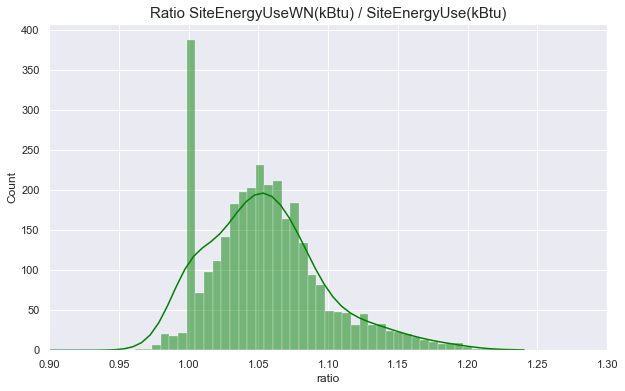

In [98]:
sns.histplot(data=ok, x='ratio', kde=True, bins=200, color='green')
plt.title('Ratio SiteEnergyUseWN(kBtu) / SiteEnergyUse(kBtu)', size=15)
#sns.histplot(data=inconst, x='ratio', kde=True, bins=200)
plt.xlim(0.9, 1.3)

print('median :', ok.ratio.median())
print('mean :', ok.ratio.mean())
print('modes :', ok.ratio.mode())  # c'est le mode qui nous indique les pics

# Site vs. Source

`'SourceEUI(kBtu/sf)'` l'**intensité de la consommation d'énergie** (EUI) est la consommation d'énergie source d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie source est l'énergie annuelle utilisée pour exploiter la propriété, y compris les pertes de production, de transmission et de distribution. L'EUI source est mesurée dans des milliers d'unités thermiques britanniques (KBTU) par pied carré.

`'SiteEUI(kBtu/sf)'` l'**intensité de la consommation d'énergie du site** (EUI) est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute. La consommation d'énergie du site est le montant annuel de toute l'énergie consommée par la propriété sur place, comme indiqué sur les factures de services publics. Le site EUI est mesuré en milliers d'unités thermiques britanniques (KBTU) par pied carré.

Etude du rapport entre :
* `'SourceEUI(kBtu/sf)'`
* `'SiteEUI(kBtu/sf)'`

Bilan :
* Rapport non constant :
    - un pic (mode) sur un rapport maximum (sauf outliers) $E_{Source} = 3.14 E_{Site}$
    - des rapports qui se distribuent ensuite entre 1 et ce maximum
    - **nb** > un ratio < 1 est aberrant a priori (les pertes sur le réseau ne peuvent être négatives).
* Exclusion de 4 en (NaN, NaN) [1768, 2321, 2480, 3348].
* Outliers hors l'intervalle 1, 3.14 :
    - 6 individus aberrants dont la valeur source est nulle [505, 513, 755, 1323, 1883, 2791]
    - 1 low outlier avec un rapport à peine supérieur à 1 (1.05) [426] (Proche de la centrale ?)
    - 2 low outliers dont les rapports sont 0.28 et 0.41, ce qui est a priori impossible [3206, 2761]
    - 3 high outliers dont les rapports sont 4.66, 5.16 et 13.72 [46, 3350, 529]

Théorie : le rapport exprime le coût réel de production de l'énergie consommée, en prenant en compte les pertes de l'opérateur sur son réseau de distribution. On peut pousser l'hypothèse - qui pourrait être vérifiée - à une déperdition qui dépend de la distance à la centrale de production. Cependant, cette dernière hypothèse est molle face à un maximum constant où se concentre la plus grande partie des individus.

# excluded : 4
# confirmed : 3207
# inconsistancies (ε = 1 / 1000) : 2985 (93.078 %)
median ratio : 2.674
mean ratio : 2.583
ratio std dev : 0.615
ratio kurtosis : 32.99
ratio skew : 1.263


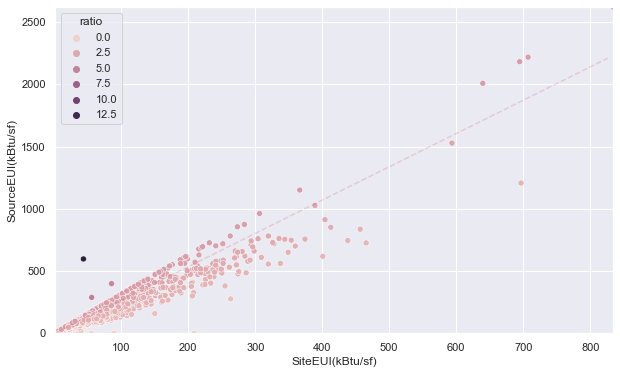

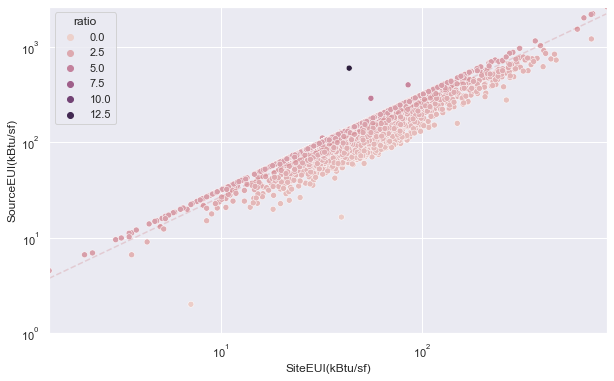

In [3]:
re, ab = exclude_aberrants(_data, ['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'])
ok, ko = assert_const_ratio(re, 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)')

Le nuage de point ne montre pas une forme linéaire bien définie.

Il forme plutôt un cône délimité par deux pentes limites.

La droite de pente la plus forte semble concentrer un nombre significatifs de points.

Aberrants :

In [5]:
# TODO : Nice-to-have (finitions) : fonction générique, tout ce qui suit réduit à une seule ligne
compared_cols = [_data.columns[28], _data.columns[26]]
compared_family_other_cols = [_data.columns[29]] + [_data.columns[27]] + list(_data.columns[30:37])
family_name = 'Energy data'
display_aberrants(_data, ab, compared_cols, compared_family_other_cols, family_name)

Identification                        ...        Energy data                 
                 id                b_type  ... NaturalGas(therms) NaturalGas(kBtu)
1768          23355  Multifamily LR (1-4)  ...                NaN              NaN
2321          25431  Multifamily LR (1-4)  ...                NaN              NaN
2480          25763  Multifamily LR (1-4)  ...                NaN              NaN
3348          50082  Multifamily LR (1-4)  ...                NaN              NaN

[4 rows x 14 columns]

Outliers :

In [6]:
# TODO : Nice-to-have (finitions) : fonction générique, tout ce qui suit réduit à une seule ligne
compared_cols = [_data.columns[28], _data.columns[26]]
compared_family_other_cols = [_data.columns[29]] + [_data.columns[27]] + list(_data.columns[30:37])
family_name = 'Energy data'
display_outliers(_data, ko, compared_cols, compared_family_other_cols, family_name)

Identification                        ...        Energy data                 
                 id                b_type  ... NaturalGas(therms) NaturalGas(kBtu)
529             716        NonResidential  ...       10060.180660        1006018.0
3350          50086  Multifamily LR (1-4)  ...           0.000000              0.0
46               59        NonResidential  ...           0.000000              0.0
1105          20868        NonResidential  ...        8878.283203         887828.0
563             757        NonResidential  ...       14160.409180        1416041.0
...             ...                   ...  ...                ...              ...
2791          26973        NonResidential  ...           0.000000              0.0
513             700        NonResidential  ...           0.000000              0.0
505             688  Multifamily MR (5-9)  ...           0.000000              0.0
1883          23682  Multifamily LR (1-4)  ...           0.000000              0.0
755           19793  Multifamily MR (5-9)  ...           0.000000              0.0

[2985 rows x 15 columns]

Intéressons-nous à la distribution fréquentielle des pentes.

On trouve une confirmation d'une ligne dense de points sur la pente ~3.14

count   : 3207
median  : 2.673972560821918
mean    : 2.5834591320382447
modes   : [3.142857142857143]
std     : 0.6148424625599092
kurt    : 32.98968168437907


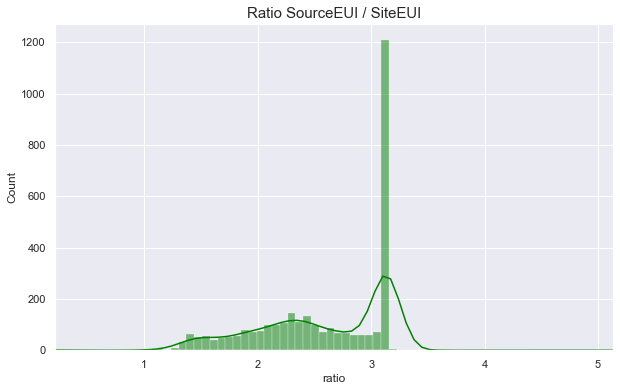

In [7]:
ratio_histo(ok.ratio, 'SourceEUI', 'SiteEUI')

Individus sur la pente principale (1/3), dont on raffine la pente au passage.

La pente s'établit à 3.1398

count   : 1180
median  : 3.1398009039528434
mean    : 3.1396993616232107
modes   : [3.142857142857143]
std     : 0.004679081434464869
kurt    : 8.55524650178334


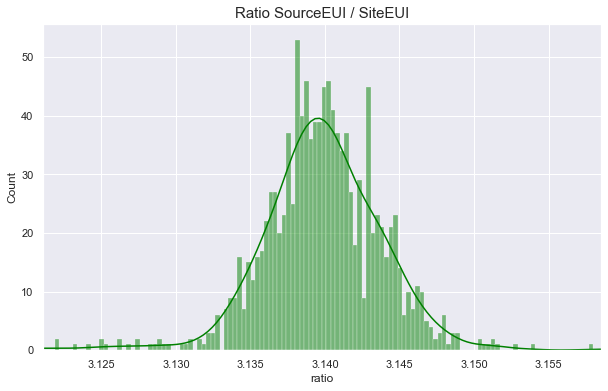

In [8]:
main_slope = ok.ratio.mode()[0]   # 3.14..
main_ratio = ok[(ok.ratio / main_slope - 1).abs() < .01].ratio
ratio_histo(main_ratio, 'SourceEUI', 'SiteEUI')

Et les autres (2/3) :

count   : 2027
median  : 2.2919464695261516
mean    : 2.2596488355852267
modes   : [0.0]
std     : 0.559539618672871
kurt    : 86.72677678153067


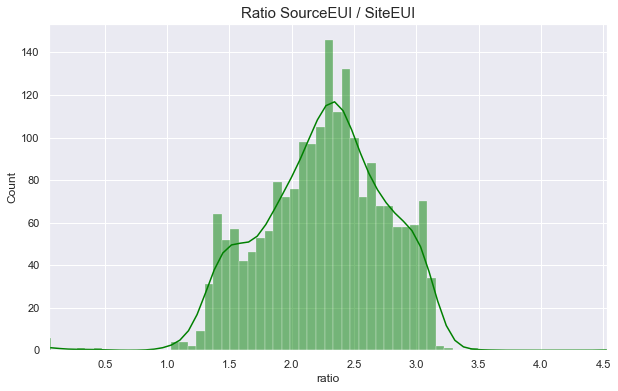

In [9]:
rest_ratio = ok.drop(index=main_ratio.index).ratio
ratio_histo(rest_ratio, 'SourceEUI', 'SiteEUI')

Matérialisation de classes + d'une feature, le gain par rapport au ratio max.

,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),ratio,const
0,81.699997,182.500000,2.233782,not consistant
1,94.800003,176.100006,1.857595,not consistant
2,96.000000,241.899994,2.519792,not consistant
3,110.800003,216.199997,1.951263,not consistant
4,114.800003,211.399994,1.841463,not consistant
...,...,...,...,...
3370,51.000000,126.000000,2.470588,not consistant
3372,59.400002,114.199997,1.922559,not consistant
3373,438.200012,744.799988,1.699680,not consistant
3374,51.000000,105.300003,2.064706,not consistant


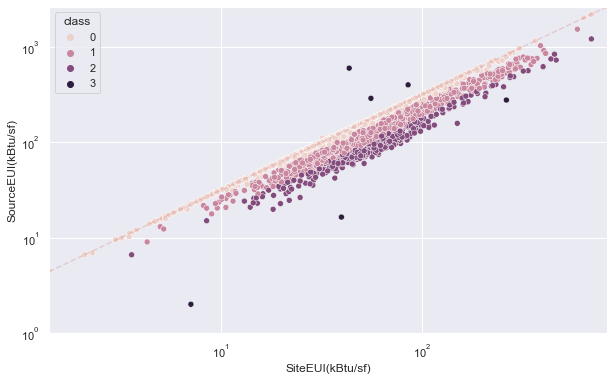

In [10]:
display(ok)

def classify(r):
    if abs(r / 3.142857 - 1) < .15:
        return 0
    elif abs(r / 2.3 - 1) < .2:
        return 1
    elif abs(r / 1.5 - 1) < .3:  # c'est ballot avec cela j'inclus en classe 3 des individus entre 1.2 et 1.25
        return 2
    else:
        return 3

ok['class'] = ok.ratio.apply(classify)
x = ok['SiteEUI(kBtu/sf)']
y = ok['SourceEUI(kBtu/sf)']
xlim = (x.min(), x.max())
ylim = (y.min(), y.max())
ax = sns.scatterplot(data=ok, x='SiteEUI(kBtu/sf)', y='SourceEUI(kBtu/sf)', hue='class')	
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.xlim(max(1, xlim[0]), xlim[1])
plt.ylim(max(1, ylim[0]), ylim[1])
xlen = xlim[1] - xlim[0]
ylen = ylim[1] - ylim[0]
x = np.arange(max(1, xlim[0]), xlim[1], xlen / 100)
y = x * 3.142857
ax.plot(x, y, 'r--', alpha=.2)
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.show()


Qui sont les outliers (classe 3) ?

In [11]:
# TODO : Nice-to-have (finitions) : fonction générique, tout ce qui suit réduit à une seule ligne
compared_cols = [_data.columns[28], _data.columns[26]]
compared_family_other_cols = [_data.columns[29]] + [_data.columns[27]] + list(_data.columns[30:37])
family_name = 'Energy data'
outliers = ok[ok['class'] == 3].dropna()
display_outliers(_data, outliers, compared_cols, compared_family_other_cols, family_name)

Identification                        ...        Energy data                 
                 id                b_type  ... NaturalGas(therms) NaturalGas(kBtu)
529             716        NonResidential  ...       10060.180660        1006018.0
3350          50086  Multifamily LR (1-4)  ...           0.000000              0.0
46               59        NonResidential  ...           0.000000              0.0
426           23854        NonResidential  ...      115080.351600       11508035.0
2761          26849        NonResidential  ...        1147.940186         114794.0
3206          49784        NonResidential  ...           0.000000              0.0
505             688  Multifamily MR (5-9)  ...           0.000000              0.0
513             700        NonResidential  ...           0.000000              0.0
755           19793  Multifamily MR (5-9)  ...           0.000000              0.0
1323          21524  Multifamily LR (1-4)  ...           0.000000              0.0
1883          23682  Multifamily LR (1-4)  ...           0.000000              0.0
2791          26973        NonResidential  ...           0.000000              0.0

[12 rows x 15 columns]

# Surface totale / intérieure et extérieure

## ✔ Vérification de $x + y = z$
**Q** - *La surface totale est-elle bien la somme des surfaces de parking et de building(s) ?*

En notant $x, y, z$ les 3 variables `'PropertyGFAParking'`, `'PropertyGFABuilding(s)'`, `'PropertyGFATotal'`

On vérifie la perfection de la relation linéaire $x + y = z$.

Pas d'exclusion ni d'outlier.

Comme conséquence, l'une des 3 variables est superflue.

# excluded : 0
# confirmed : 3211
consistancy : all is consistant!
median ratio : 1.0
mean ratio : 1.0
ratio std dev : 0.0
ratio kurtosis : 0
ratio skew : 0


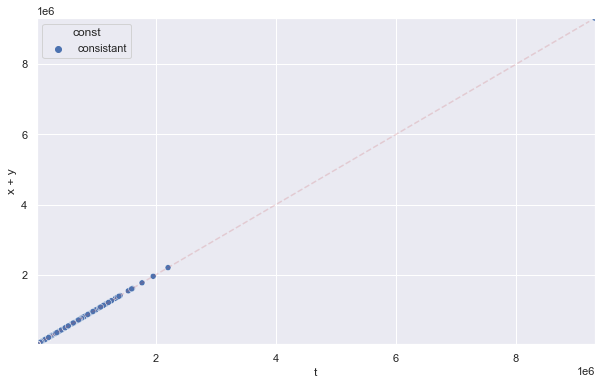

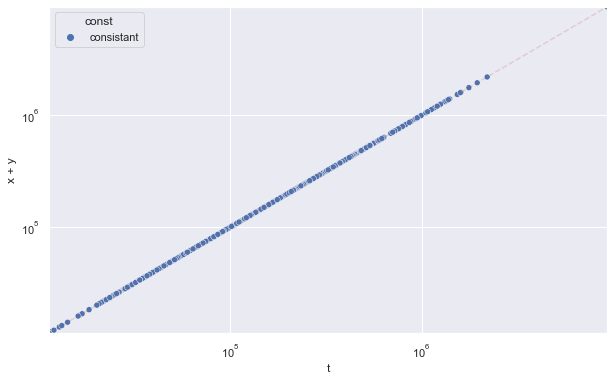

In [19]:
ok, ko, re, ab = assert_relation(
    data=_data,
    features=['PropertyGFAParking', 'PropertyGFABuilding(s)'],
    target='PropertyGFATotal',
    relation='x + y'
)

## Proportions relatives des deux surfaces

L'observation principale est qu'il y a une proportion majoritaire (85 %) d'immeubles purs (sans surface extérieure).

La seconde est que le profil type d'une propriété mixte est 25 % de surface extérieure pour 75 % d'intérieure.

,x,y,t,x + y,%x,%y
0,0,88434.0,88434.0,88434,0.000000,1.000000
1,15064,88502.0,103566.0,103566,0.145453,0.854547
2,196718,759392.0,956110.0,956110,0.205748,0.794252
3,0,61320.0,NaN,61320,NaN,NaN
4,62000,113580.0,175580.0,175580,0.353115,0.646885
...,...,...,...,...,...,...
3370,0,18261.0,18261.0,18261,0.000000,1.000000
3371,0,12294.0,12294.0,12294,0.000000,1.000000
3372,0,16000.0,16000.0,16000,0.000000,1.000000
3373,0,13157.0,13157.0,13157,0.000000,1.000000


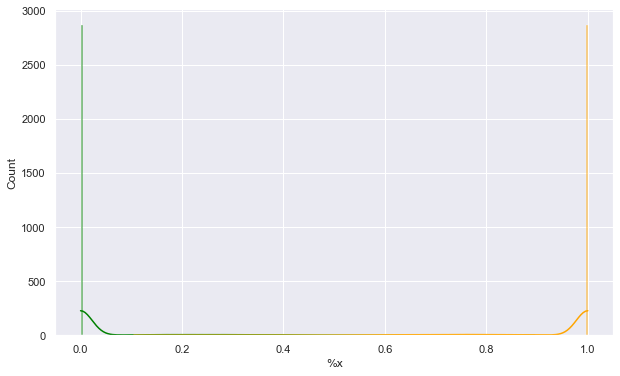

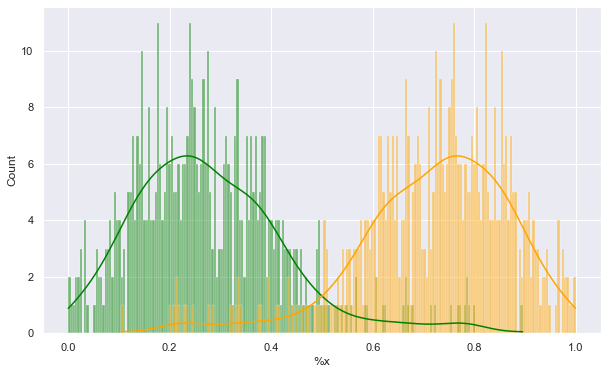

In [24]:
re = re.copy()
re[r'%x'] = re.x / re.t
re[r'%y'] = re.y / re.t
display(re)
#sns.scatterplot(data=area, x=r'%x', y=r'%y') #, hue='class')
sns.histplot(data=re, x=r'%x', kde=True, bins=200, color='green')
sns.histplot(data=re, x=r'%y', kde=True, bins=200, color='orange')
plt.show()
sns.histplot(data=re[re.x > 0], x=r'%x', kde=True, bins=200, color='green')
sns.histplot(data=re[re.x > 0], x=r'%y', kde=True, bins=200, color='orange')
plt.show()	

### Les buildings purs

Il représentent 85 % de la population.

In [25]:
display(re[re.x == 0])

,x,y,t,x + y,%x,%y
0,0,88434.0,88434.0,88434,0.0,1.0
3,0,61320.0,NaN,61320,NaN,NaN
6,0,83008.0,83008.0,83008,0.0,1.0
7,0,102761.0,102761.0,102761,0.0,1.0
8,0,163984.0,163984.0,163984,0.0,1.0
...,...,...,...,...,...,...
3370,0,18261.0,18261.0,18261,0.0,1.0
3371,0,12294.0,12294.0,12294,0.0,1.0
3372,0,16000.0,16000.0,16000,0.0,1.0
3373,0,13157.0,13157.0,13157,0.0,1.0


### Les propriétés avec espace extérieur

La médiane de la part de surface totale consacrée aux espaces extérieurs (parkings) est de 25 % avec un écart type de 15 %.

In [26]:
a = re[re.x > 0].copy()
c, s, mn, md, st = a.count(), a.sum(), a.mean(), a.median(), a.std()
a.loc['count'] = c
a.loc['sum'] = s
a.loc['mean'] = mn
a.loc['median'] = md
a.loc['std'] = st
display(a)

,x,y,t,x + y,%x,%y
1,1.506400e+04,8.850200e+04,1.035660e+05,1.035660e+05,0.145453,0.854547
2,1.967180e+05,7.593920e+05,9.561100e+05,9.561100e+05,0.205748,0.794252
4,6.200000e+04,1.135800e+05,1.755800e+05,1.755800e+05,0.353115,0.646885
5,3.719800e+04,6.009000e+04,9.728800e+04,9.728800e+04,0.382349,0.617651
9,1.496000e+03,6.221600e+04,6.371200e+04,6.371200e+04,0.023481,0.976519
...,...,...,...,...,...,...
count,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,504.000000,504.000000
sum,2.701315e+07,6.941542e+07,9.642857e+07,9.642857e+07,140.192919,363.807081
mean,5.359752e+04,1.377290e+05,1.913265e+05,1.913265e+05,0.278161,0.721839
median,2.648150e+04,7.482850e+04,1.030150e+05,1.030150e+05,0.259529,0.740471


# Surface totale / sa ventilation par usage

**Q** - *La surface totale est-elle systématiquement la sommes des surfaces par usage ?*

**NB** - le cas du parking est spécial : il faut vérifier qu'il y a cohérence entre la surface indiquée dans `'PropertyGFAParking'` et celle indiquée dans l'éventuel des 3 usages ventilés ayant le label `'Parking'`.

Bilan :
* Pas d'exclusion
* 72 % d'individus vérifient la relation (erreur tolérée 1 pour 1000).
* 28 % ne la vérifient pas ... <mark>Analyse à poursuivre en réutilisant l'histogramme pentes</mark>
* Pour les 593 propriétés avec parking, les inconsistances dépassent les consistances.. quelque chose ne va pas.

# excluded : 0
# confirmed : 3211
# inconsistancies (ε = 1 / 1000) : 901 (28.060 %)
median ratio : 1.0
mean ratio : 1.002
ratio std dev : 0.254
ratio kurtosis : 99.381
ratio skew : 6.245


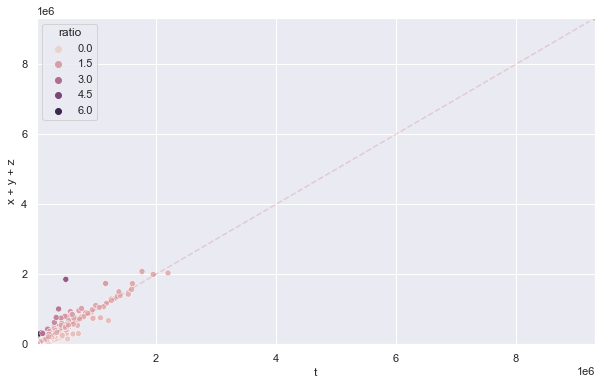

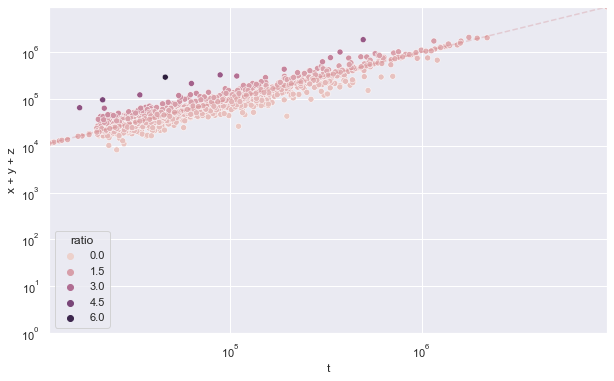

In [55]:
# attention, les 3 surfaces ne sont pas nécessairement renseignées
# pour ne pas mettre en échec la vérification, il faut remplacer les NA par 0
__data = _data.copy()
__data.LargestPropertyUseTypeGFA.fillna(0, inplace=True)
__data.SecondLargestPropertyUseTypeGFA.fillna(0, inplace=True)
__data.ThirdLargestPropertyUseTypeGFA.fillna(0, inplace=True)
ok, ko, re, ab = assert_relation(
    data=__data,
    features=['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'],
    target='PropertyGFATotal',
    relation='x + y + z'
)

Distribution des pentes

median : 1.0
mean : 1.0019900082278819
modes : 0    1.0
Name: ratio, dtype: float64


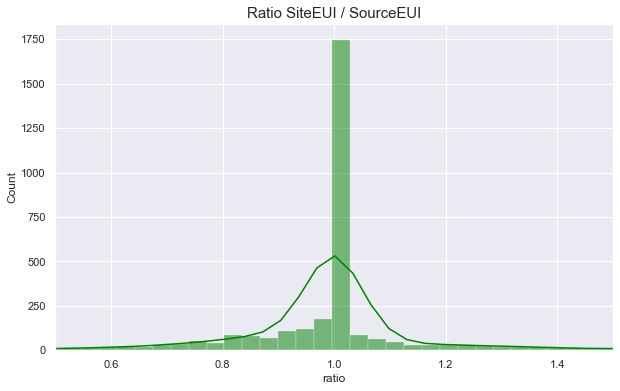

In [59]:
sns.histplot(data=ok, x='ratio', kde=True, bins=200, color='green')
plt.title('Ratio SiteEUI / SourceEUI', size=15)
#sns.histplot(data=inconst, x='ratio', kde=True, bins=200)
plt.xlim(0.5, 1.5)

print('median :', ok.ratio.median())
print('mean :', ok.ratio.mean())
print('modes :', ok.ratio.mode())  # c'est le mode qui nous indique les pics

median : 1.0
mean : 1.0019900082278819
modes : 0    1.0
Name: ratio, dtype: float64


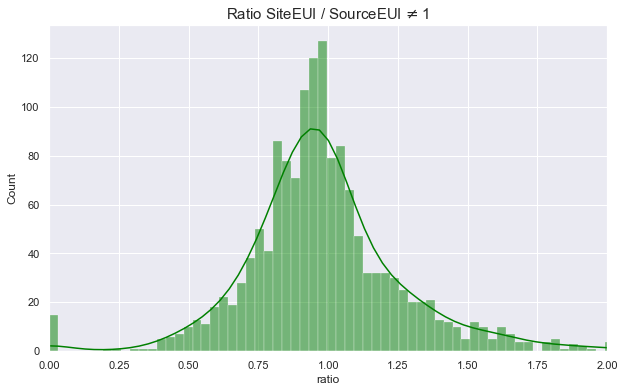

In [67]:
r = ok.ratio
sns.histplot(data=ok[(r - 1).abs() > 0.01], x='ratio', kde=True, bins=200, color='green')
plt.title(r'Ratio SiteEUI / SourceEUI $\ne$ 1', size=15)
#sns.histplot(data=inconst, x='ratio', kde=True, bins=200)
plt.xlim(0, 2)

print('median :', ok.ratio.median())
print('mean :', ok.ratio.mean())
print('modes :', ok.ratio.mode())  # c'est le mode qui nous indique les pics

28 % d'outliers c'est beaucoup!

Les low outliers peuvent s'expliquer par le fait que des surfaces d'usages annexes complètent les 3 surfaces d'usages principaux.

En revanche, les high outliers posent un sérieux problème puisqu'ils indiquent une surface totale supérieure à celle des usages particuliers. La seule explication autre que l'erreur, c'est le fait que des surfaces soient décomptées plusieurs fois en raison d'usages mixtes. Il faut pousser l'analyse sur cet aspect en observant de plus près les cas.

In [31]:
areas = _data[list(_data.columns[1:4]) + list(_data.columns[14:24])]
low_outliers = ko[ko.ratio < 1]
high_outliers = ko[ko.ratio > 1]
display(low_outliers)
display(areas.loc[low_outliers.index])
display(high_outliers)
display(areas.loc[high_outliers.index])


,t,x + y + z,ratio
2,956110,756493.0,0.791220
9,63712,56132.0,0.881027
10,153163,133884.0,0.874128
18,57452,41688.0,0.725614
27,171866,128909.0,0.750055
...,...,...,...
3332,175844,123554.0,0.702634
3334,48230,42600.0,0.883268
3344,260051,210125.0,0.808015
3348,36685,0.0,0.000000


,BuildingType,PrimaryPropertyType,PropertyName,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
2,NonResidential,Hotel,5673-The Westin Seattle,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN
9,Multifamily MR (5-9),Mid-Rise Multifamily,Lyon Building,63712,1496,62216,Multifamily Housing,Multifamily Housing,56132.0,NaN,NaN,NaN,NaN
10,NonResidential,Hotel,Hotel Monaco Seattle,153163,19279,133884,Hotel,Hotel,133884.0,NaN,NaN,NaN,NaN
18,NonResidential,Mixed Use Property,The Rainier Club,57452,0,57452,"Office, Other, Other - Lodging/Residential, Re...",Social/Meeting Hall,16442.0,Restaurant,15505.0,Office,9741.0
27,NonResidential,Hotel,Marriott Springhill Suites (33),171866,38281,133585,Hotel,Hotel,128909.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,Multifamily MR (5-9),Mid-Rise Multifamily,Smith & Burns Apartments,175844,52045,123799,"Multifamily Housing, Parking",Multifamily Housing,99554.0,Parking,24000.0,NaN,NaN
3334,Multifamily LR (1-4),Low-Rise Multifamily,Wedgewood Estates Building A,48230,0,48230,"Multifamily Housing, Parking",Multifamily Housing,26175.0,Parking,16425.0,NaN,NaN
3344,Multifamily MR (5-9),Mid-Rise Multifamily,Astro Apartments,260051,90503,169548,"Multifamily Housing, Parking",Multifamily Housing,145784.0,Parking,64341.0,NaN,NaN
3348,Multifamily LR (1-4),Low-Rise Multifamily,STREAM FIFTEEN,36685,8254,28431,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,t,x + y + z,ratio
13,315952,353111.0,1.117610
16,103911,130000.0,1.251071
35,494835,1856706.0,3.752172
36,714095,963000.0,1.348560
40,52554,58878.0,1.120333
...,...,...,...
3333,319481,396398.0,1.240756
3349,213952,289913.0,1.355038
3351,41403,46955.0,1.134097
3352,25442,34164.0,1.342819


,BuildingType,PrimaryPropertyType,PropertyName,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
13,NonResidential,Hotel,Crowne Plaza Hotel Seattle,315952,57600,258352,"Hotel, Parking",Hotel,295511.0,Parking,57600.0,NaN,NaN
16,NonResidential,Other,Downtown Seattle YMCA,103911,0,103911,"Fitness Center/Health Club/Gym, Office, Swimmi...",Fitness Center/Health Club/Gym,90000.0,Office,40000.0,Swimming Pool,0.0
35,Campus,Mixed Use Property,Plant 2 Site,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturin...",Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0
36,NonResidential,Warehouse,Seattle 11-13,714095,0,714095,"Non-Refrigerated Warehouse, Office, Refrigerat...",Non-Refrigerated Warehouse,616000.0,Refrigerated Warehouse,276000.0,Office,71000.0
40,NonResidential,Small- and Mid-Sized Office,El Centro de la Raza,52554,0,52554,"Office, Other - Education",Office,51029.0,Other - Education,7849.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3333,Multifamily HR (10+),High-Rise Multifamily,Cirrus,319481,41915,277566,"Multifamily Housing, Office, Other - Lodging/R...",Multifamily Housing,308680.0,Other - Lodging/Residential,52538.0,Parking,35180.0
3349,Multifamily MR (5-9),Mid-Rise Multifamily,Rooster Apartments,213952,51739,162213,"Multifamily Housing, Parking",Multifamily Housing,154913.0,Parking,135000.0,NaN,NaN
3351,Multifamily LR (1-4),Low-Rise Multifamily,Vibe Apartments,41403,0,41403,"Multifamily Housing, Parking",Multifamily Housing,42014.0,Parking,4941.0,NaN,NaN
3352,Multifamily LR (1-4),Low-Rise Multifamily,Atrium Apartments,25442,604,24838,"Multifamily Housing, Parking, Personal Service...",Multifamily Housing,25052.0,Parking,5582.0,Restaurant,3530.0


#### Le cas des parkings

In [32]:
def hlookup_parkings(data):
    _1st_is_parking = data[data.LargestPropertyUseType == 'Parking'].index
    _2nd_is_parking = data[data.SecondLargestPropertyUseType == 'Parking'].index
    _3rd_is_parking = data[data.ThirdLargestPropertyUseType == 'Parking'].index
    pos = pd.Series(data=-1, index=data.index, name='pos')
    pos[_1st_is_parking] = 1
    pos[_2nd_is_parking] = 2
    pos[_3rd_is_parking] = 3
    gfa = pd.Series(data=0, index=data.index, name='gfa')
    gfa[_1st_is_parking] = data.LargestPropertyUseTypeGFA[_1st_is_parking]
    gfa[_2nd_is_parking] = data.SecondLargestPropertyUseTypeGFA[_2nd_is_parking]
    gfa[_3rd_is_parking] = data.ThirdLargestPropertyUseTypeGFA[_3rd_is_parking]
    return pos, gfa
    

s_parkings = _data[['PropertyGFAParking']].copy()
s_parkings.columns = ['s']
s_parkings['p'], s_parkings['s_2'] = hlookup_parkings(data)
s_parkings['s - s_2'] = s_parkings.s - s_parkings.s_2

display(s_parkings)

,s,p,s_2,s - s_2
0,0,-1,0.0,0.0
1,15064,2,15064.0,0.0
2,196718,-1,0.0,196718.0
3,0,-1,0.0,0.0
4,62000,2,68009.0,-6009.0
...,...,...,...,...
3370,0,-1,0.0,0.0
3372,0,-1,0.0,0.0
3373,0,-1,0.0,0.0
3374,0,-1,0.0,0.0


Surprise : les cas inconsistants (144 + 172) dépassent en nombre les cas consistants (131 + (146)).

Le cas des 146 surfaces de parking non reportées dans les détails n'est pas nécessairement inconsistant.

Pour s'en assurer, il faut vérifier s'il n'y a pas 3 usages dont les surfaces dépassent celle du parking.

In [33]:
no_parking = s_parkings[(s_parkings.s == 0) & (s_parkings.s_2 == 0)]
print_subtitle(f'No parking ({no_parking.shape[0]})')
display(no_parking.head(3))

parking_ok = s_parkings[(s_parkings.s > 0) & (s_parkings['s - s_2'] == 0)]
print_subtitle(f'Parking areas are consistant ({parking_ok.shape[0]})')
display(parking_ok.head(3))

parking_ko_1 = s_parkings[(s_parkings.s > 0) & (s_parkings['s - s_2'] > 0) & (s_parkings.s_2 == 0)]
print_subtitle(f'Parking not in detailed uses s > 0, s_2 = 0 ({parking_ko_1.shape[0]})')
display(parking_ko_1)

parking_ko_2 = s_parkings[(s_parkings['s - s_2'] > 0) & (s_parkings.s_2 > 0)]
print_subtitle(f'Parking is under accounted s > s_2 > 0 ({parking_ko_2.shape[0]})')
display(parking_ko_2)

parking_ko_3 = s_parkings[(s_parkings['s - s_2'] < 0) & (s_parkings.s > 0)]
print_subtitle(f'Parking is over accounted s_2 > s > 0 ({parking_ko_3.shape[0]})')
display(parking_ko_3)


No parking (2133)


,s,p,s_2,s - s_2
0,0,-1,0.0,0.0
3,0,-1,0.0,0.0
6,0,-1,0.0,0.0



Parking areas are consistant (131)


,s,p,s_2,s - s_2
1,15064,2,15064.0,0.0
13,57600,2,57600.0,0.0
14,25200,2,25200.0,0.0



Parking not in detailed uses s > 0, s_2 = 0 (146)


,s,p,s_2,s - s_2
2,196718,-1,0.0,196718.0
5,37198,-1,0.0,37198.0
9,1496,-1,0.0,1496.0
10,19279,-1,0.0,19279.0
11,61161,-1,0.0,61161.0
...,...,...,...,...
3338,4222,-1,0.0,4222.0
3346,12223,-1,0.0,12223.0
3348,8254,-1,0.0,8254.0
3353,4850,-1,0.0,4850.0



Parking is under accounted s > s_2 > 0 (144)


,s,p,s_2,s - s_2
15,57000,2,49000.0,8000.0
49,146694,2,117668.0,29026.0
77,303707,2,185014.0,118693.0
78,25930,2,21454.0,4476.0
202,18504,2,17570.0,934.0
...,...,...,...,...
3343,14383,2,10664.0,3719.0
3344,90503,2,64341.0,26162.0
3355,8908,2,8126.0,782.0
3356,85028,3,84002.0,1026.0



Parking is over accounted s_2 > s > 0 (72)


,s,p,s_2,s - s_2
4,62000,2,68009.0,-6009.0
26,30301,2,42000.0,-11699.0
54,28200,2,28300.0,-100.0
65,9341,2,20868.0,-11527.0
68,44766,2,51537.0,-6771.0
...,...,...,...,...
3251,31916,2,32227.0,-311.0
3329,197659,2,202178.0,-4519.0
3349,51739,2,135000.0,-83261.0
3350,2784,2,2791.0,-7.0


# Energie / sa ventilation

**Q** - *L'énergie totale consommée est-elle bien la somme des 3 types d'énergies (vapeur, électricité, gaz) ?*

29 outliers :
* dans la majorité des cas, la consommation totale est supérieure aux 3 énergies. Cela laisse entendre, ce qui peut certainement être vérifié, que ces bâtiments consomment d'autres sources d'énergie.
* dans quelques cas, c'est l'inverse. Ce sont probablement les immeubles à consommation négative (électricité) ce qui signifie qu'ils produisent de l'énergie.

<mark>Voir la corrélation entre cette propriété et le rapport *source* / *site*.</mark>

# excluded : 4
# confirmed : 3207
# inconsistancies (ε = 1 / 1000) : 29 (0.904 %)
median ratio : 1.0
mean ratio : 0.997
ratio std dev : 0.049
ratio kurtosis : 345.407
ratio skew : -15.675


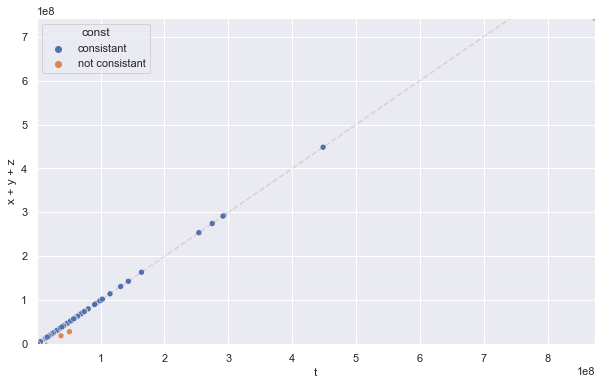

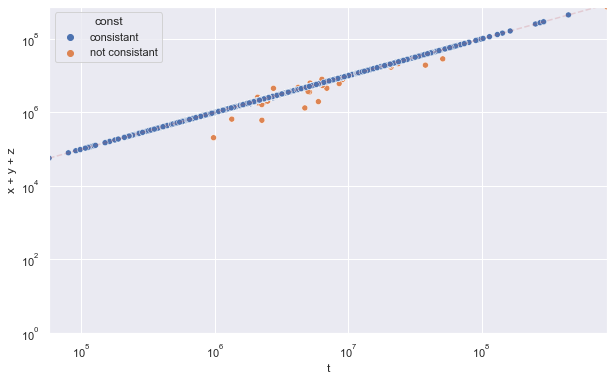

In [34]:
ok, ko, re, ab = assert_relation(
    data=_data,
    features=['NaturalGas(kBtu)', 'Electricity(kBtu)', 'SteamUse(kBtu)'],
    target='SiteEnergyUse(kBtu)',
    relation='x + y + z'
)

Qui sont les outliers ?

Pour quasiment tous, la somme minore le total enregistré.

La meilleure hypothèse est que cela correspond aux sources d'énergies autres que la vapeur, l'électricité et le gaz, comme notamment le fioul et autres sources 'sales'

https://en.wikipedia.org/wiki/Bullitt_Center : qui produit plus d'électricité qu'il n'en consomme, a été conçu comme le bâtiment commerciel le plus vert du monde.

In [35]:
ko['t - (x + y + z)'] = ko.t - ko['x + y + z']
display(ko)

,t,x + y + z,ratio,t - (x + y + z)
69,2.365898e+07,21200976.0,0.896107,2.458002e+06
71,2.095503e+07,17016015.0,0.812025,3.939011e+06
75,2.072325e+07,18649906.0,0.899951,2.073342e+06
403,9.058916e+06,7877393.0,0.869573,1.181523e+06
505,5.974994e+06,1966947.0,0.329197,4.008046e+06
513,1.252517e+07,0.0,0.000000,1.252517e+07
563,5.177270e+06,6287167.0,1.214379,-1.109896e+06
601,3.795171e+07,19295187.0,0.508414,1.865652e+07
675,1.339221e+06,656634.0,0.490311,6.825866e+05
755,2.321336e+06,1879677.0,0.809739,4.416590e+05


### Distribution des proportions de chaque énergie dans le mix

,x,y,z,t,x + y + z,%x,%y,%z
0,1.276453e+06,3.946027e+06,2003882.00,7.226362e+06,7.226362e+06,0.176638,0.546060,0.277302
1,5.145082e+06,3.242851e+06,0.00,8.387933e+06,8.387933e+06,0.613391,0.386609,0.000000
2,1.493800e+06,4.952666e+07,21566554.00,7.258702e+07,7.258702e+07,0.020579,0.682307,0.297113
3,1.811213e+06,2.768924e+06,2214446.25,6.794584e+06,6.794583e+06,0.266567,0.407519,0.325913
4,8.803998e+06,5.368607e+06,0.00,1.417261e+07,1.417260e+07,0.621198,0.378802,0.000000
...,...,...,...,...,...,...,...,...
3370,2.997200e+05,6.323620e+05,0.00,9.320821e+05,9.320820e+05,0.321560,0.678440,0.000000
3372,5.537300e+05,3.965461e+05,0.00,9.502762e+05,9.502760e+05,0.582704,0.417296,0.000000
3373,3.973739e+06,1.792159e+06,0.00,5.765898e+06,5.765898e+06,0.689180,0.310820,0.000000
3374,3.706010e+05,3.488702e+05,0.00,7.194712e+05,7.194712e+05,0.515102,0.484898,0.000000


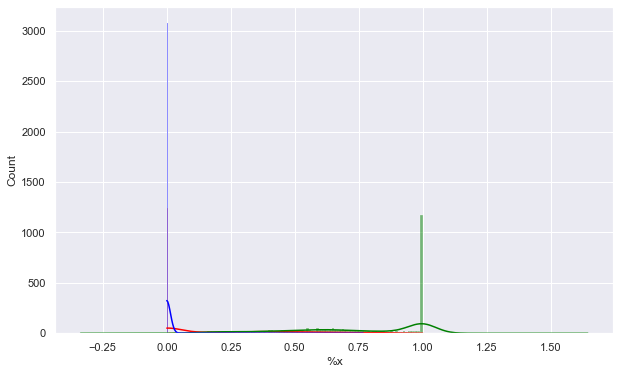

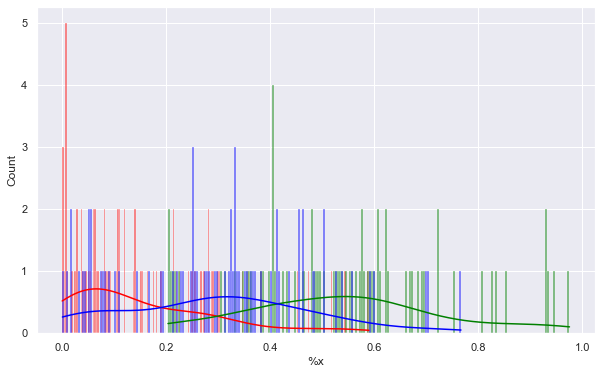

In [37]:
re = re.copy()
re[r'%x'] = re.x / re.t
re[r'%y'] = re.y / re.t
re[r'%z'] = re.z / re.t
display(re)
#sns.scatterplot(data=area, x=r'%x', y=r'%y') #, hue='class')
sns.histplot(data=re, x=r'%x', kde=True, bins=200, color='red')
sns.histplot(data=re, x=r'%y', kde=True, bins=200, color='green')
sns.histplot(data=re, x=r'%z', kde=True, bins=200, color='blue')
plt.show()
sns.histplot(data=re[(re.x > 0) & (re.y > 0) & (re.z > 0)], x=r'%x', kde=True, bins=200, color='red')
sns.histplot(data=re[(re.x > 0) & (re.y > 0) & (re.z > 0)], x=r'%y', kde=True, bins=200, color='green')
sns.histplot(data=re[(re.x > 0) & (re.y > 0) & (re.z > 0)], x=r'%z', kde=True, bins=200, color='blue')
plt.show()

In [38]:
a = re.copy()
c, s, mn, md, st = a.count(), a.sum(), a.mean(), a.median(), a.std()
a.loc['count'] = c
a.loc['sum'] = s
a.loc['mean'] = mn
a.loc['median'] = md
a.loc['std'] = st
display(a)

,x,y,z,t,x + y + z,%x,%y,%z
0,1.276453e+06,3.946027e+06,2.003882e+06,7.226362e+06,7.226362e+06,0.176638,0.546060,0.277302
1,5.145082e+06,3.242851e+06,0.000000e+00,8.387933e+06,8.387933e+06,0.613391,0.386609,0.000000
2,1.493800e+06,4.952666e+07,2.156655e+07,7.258702e+07,7.258702e+07,0.020579,0.682307,0.297113
3,1.811213e+06,2.768924e+06,2.214446e+06,6.794584e+06,6.794583e+06,0.266567,0.407519,0.325913
4,8.803998e+06,5.368607e+06,0.000000e+00,1.417261e+07,1.417260e+07,0.621198,0.378802,0.000000
...,...,...,...,...,...,...,...,...
count,3.207000e+03,3.207000e+03,3.207000e+03,3.207000e+03,3.207000e+03,3207.000000,3207.000000,3207.000000
sum,4.449748e+09,1.218827e+10,9.151453e+08,1.776572e+10,1.755316e+10,807.734262,2348.795539,41.187977
mean,1.387511e+06,3.800520e+06,2.853587e+05,5.539669e+06,5.473390e+06,0.251866,0.732396,0.012843
median,3.194000e+05,1.187175e+06,0.000000e+00,1.809587e+06,1.803753e+06,0.179785,0.775504,0.000000


# Energie, surface et énergie/surface

Là, ce n'est pas très clean : comment ça s'explique ?

Zoomer.

# excluded : 0
# confirmed : 3211
# inconsistancies (ε = 1 / 1000) : 1198 (37.309 %)
median ratio : 0.999
mean ratio : 0.935
ratio std dev : 0.235
ratio kurtosis : 130.383
ratio skew : 7.016


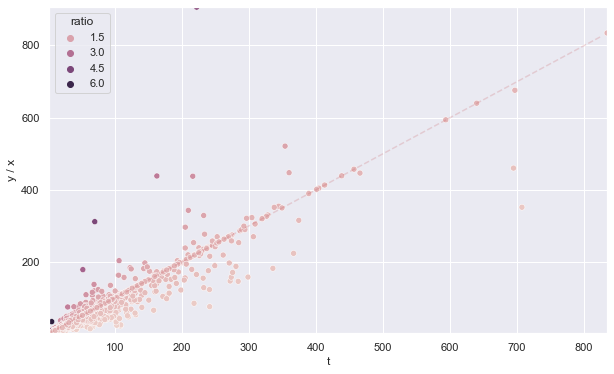

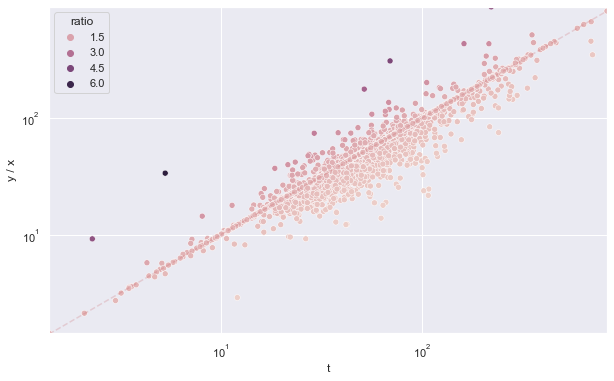

In [39]:
ok, ko, re, ab = assert_relation(
    data=_data,
    features=['PropertyGFATotal', 'SiteEnergyUse(kBtu)'],
    target='SiteEUI(kBtu/sf)',
    relation='y / x'
)

median : 0.9992036193584017
mean : 0.9354739299577786
modes : 0       0.201835
1       0.220833
2       0.227369
3       0.233190
4       0.238421
          ...   
3206    3.437694
3207    4.005543
3208    4.087194
3209    4.470185
3210    6.375433
Name: ratio, Length: 3211, dtype: float64


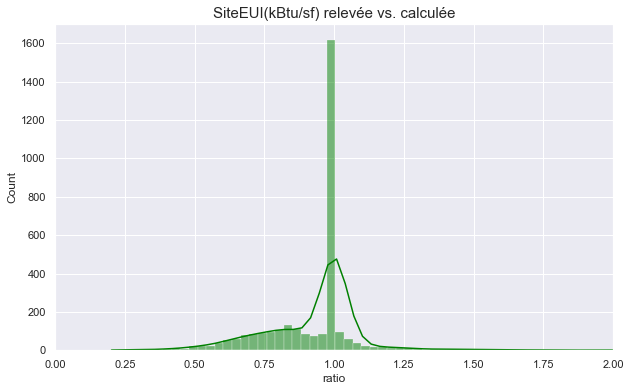

In [40]:
sns.histplot(data=ok, x='ratio', kde=True, bins=200, color='green')
plt.title('SiteEUI(kBtu/sf) relevée vs. calculée', size=15)
plt.xlim(0, 2)

print('median :', ok.ratio.median())
print('mean :', ok.ratio.mean())
print('modes :', ok.ratio.mode())  # c'est le mode qui nous indique les pics

# ✔ Emissions, surface et émissions/surface

Bilan :
* Rapport presque parfait : $I = 1000 G / S$ ($\sigma=0.017$)
* Exclusion de 4 dont les émissions sont (NaN, NaN) [1768, 2321, 2480, 3348] (idem gaz, électricité).
* 8 outliers qui s'expliquent tous par l'erreur de troncature (valeurs trop faibles cf. scale) [34, 380, 595, 609, 1049, 1658, 1994, 3206]

Conséquences :
* exclusion des 4 (NaN, NaN) du jeu de données (vérifier : si leur surface, et donc leur impact sur le résultat final, est négligeable).
* Ne conserver que les intensités, mais avec recalculer les valeurs pour évacuer l'erreur de troncature (précision actuelle à 10-2 insuffisante) : voir `seattle_commons.get_fixed_ghge_intensity`.

# excluded : 4
# confirmed : 3207
# inconsistancies (ε = 1 / 1000) : 8 (0.249 %)
median ratio : 1.0
mean ratio : 1.0
ratio std dev : 0.017
ratio kurtosis : 238.779
ratio skew : 7.945


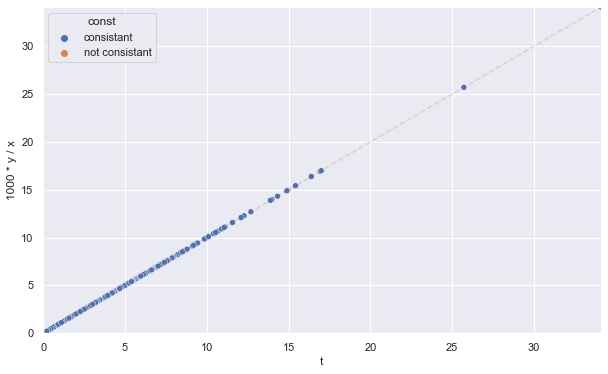

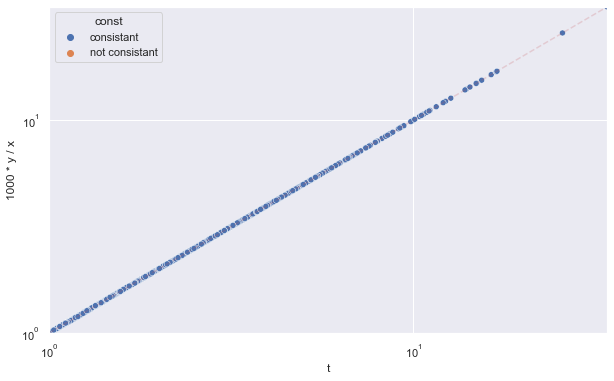

In [41]:
ok, ko, re, ab = assert_relation(
    data=_data,
    features=['PropertyGFATotal', 'TotalGHGEmissions'],
    target='GHGEmissionsIntensity',
    relation='1000 * y / x'
)

In [42]:
# aberrant : les individus dont les émissions ne sont pas renseignées
display(ab)

,x,y,t,1000 * y / x
1768,29357,NaN,NaN,NaN
2321,28472,NaN,NaN,NaN
2480,30420,NaN,NaN,NaN
3348,36685,NaN,NaN,NaN


In [43]:
# erreurs de troncature sur les individus dont les émissions sont faibles
display(ko)

,t,1000 * y / x,ratio
34,0.04,0.035612,0.890300
380,0.02,0.024944,1.247189
595,0.01,0.014780,1.478011
609,0.02,0.024614,1.230719
1049,0.03,0.033433,1.114448
1658,0.03,0.025792,0.859725
1994,0.04,0.044049,1.101236
3206,-0.02,-0.015385,0.769231


# Localisation géographique

Avec la latitude et la longitude à l'échelle d'une ville, on peut déjà faire un scatter. A cette échelle, pas de problème de projection sphérique.

En bonus, on peut modifier la couleur suivant la couleur du quatier, et chacun des autres découpages administratifs.

En superbonus, insertion en fond de l'image aérienne de Seattle.

Le next step, c'est geopandas : https://geopandas.org/en/stable/gallery/plotting_basemap_background.html


In [24]:
import os
print(os.getcwd())

c:\Users\franc\Projects\pepper_carbon-neutral_seattle\jupyter


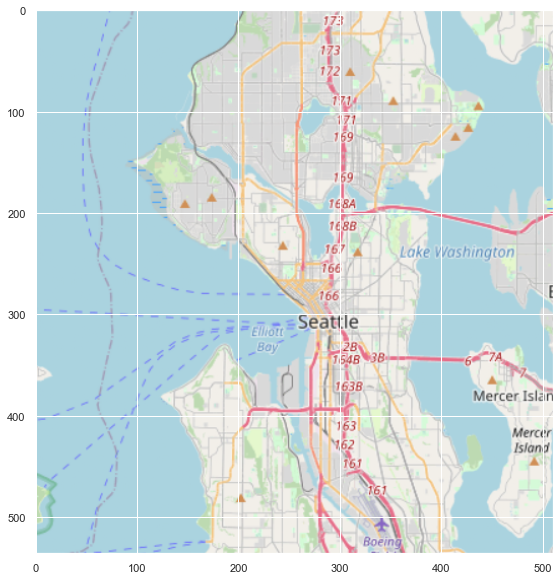

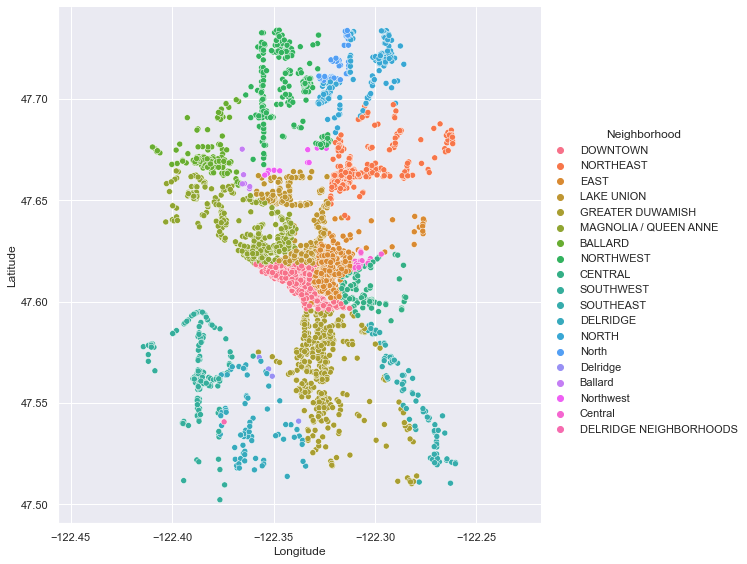

In [36]:
import matplotlib.image as mpimg
img = mpimg.imread('seattle_map.png')
#f, ax = plt.subplots()
plt.imshow(img, zorder=.5)
import seaborn as sns
plot = sns.relplot(x='Longitude', y='Latitude', hue='Neighborhood', data=_data, height=8)
#plot.axes[0, 0].imshow(img, alpha=.5, zorder=1)
plt.axis('equal')
plt.show()

# le next 

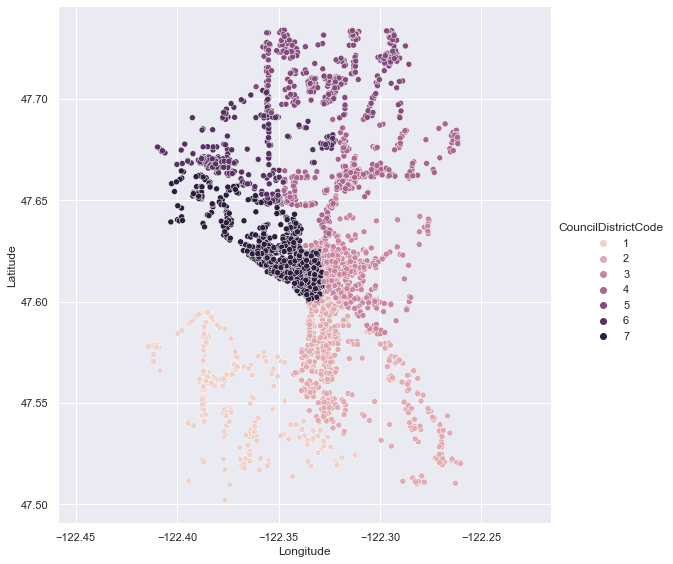

In [48]:
import seaborn as sns
sns.relplot(x='Longitude', y='Latitude', hue='CouncilDistrictCode', data=_data, height=8)
plt.axis('equal')
plt.show()

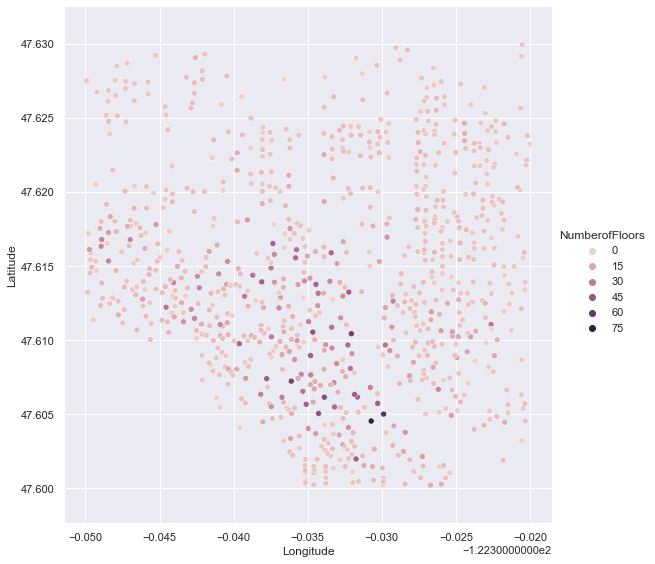

In [54]:
import seaborn as sns
#plt.xlim([-122.35, -122.32])
#plt.ylim([47.60, 47.63])

lng_limits = (-122.35 < _data.Longitude) & (_data.Longitude < -122.32)
lat_limits = (47.60 < _data.Latitude) & (_data.Latitude < 47.63)
_downtown = _data[lng_limits & lat_limits]

sns.relplot(x='Longitude', y='Latitude', hue='NumberofFloors', data=_downtown, height=8)
plt.axis('equal')
plt.show()